# Sprawozdanie - Lab 4

## Autor: Wiktor Sędzimir

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import timeit
import random

In [2]:
def measure_execution_time(function, *data):
    return timeit.timeit(lambda: function(*data), number=1)

def get_rand_lowercase_char():
    return chr(ord('a') + random.randint(0, 25))

def get_random_text(size: int):
    return ''.join((get_rand_lowercase_char() for _ in range(size)))

In [11]:
def plot_approximated(axis: plt.Axes, xs, ys, deg, label = None, title = None, **kwargs):
    approx_poly = np.poly1d(np.polyfit(xs, ys, deg))
    approx_xs = np.linspace(min(xs), max(xs), 100)
    axis.plot(approx_xs, approx_poly(approx_xs), label = label, **kwargs)
    axis.scatter(xs, ys, **kwargs)
    if label is not None:
        axis.legend()
    if title is not None:
        axis.set_title(title)

## Zadanie algorytm Ukkonena

#### Analiza złożoności

Dzięki zastosowaniu optymalizacji:
1. Technika skip/count
2. Reguła 3 (reguła łącza sufiksowego)
3. Technika wskaźnika końcowego

Moja implementacja algorytmu Ukkonena ma złożoność liniową ```O(n)```.

In [4]:
from __future__ import annotations
from typing import Optional
from collections import deque

class IntRef:
    def __init__(self, value):
        self.value = value

class Node:
    text: str = ""
    def __init__(self, end: IntRef, start: int = -1, id: int = -1, suffix_link: Optional[Node] = None):
        self.children: dict[str, Node] = {}
        self.suffix_link: Optional[Node] = suffix_link
        self.start: int = start
        self.end: IntRef = end
        self.id: int = id

    def width(self):
        return self.end.value - self.start + 1

    def debug_str(self):
        return f"Node(\"{self.text[self.start:self.end.value + 1]}\", start: {self.start}, end: {self.end.value} id: {self.id}, link: {self.suffix_link})"

    def __repr__(self):
        return f"Node(\"{self.text[self.start:self.end.value + 1]}\")"

class SuffixTree:
    def __init__(self, text: str):
        """
        Construct a suffix tree for the given text using Ukkonen's algorithm.

        Args:
            text: The input text for which to build the suffix tree
        """
        self.guardian: str = "$"
        self.end_ref: IntRef = IntRef(0)
        self.text: str = text + self.guardian
        self.root: Node = Node(IntRef(-1), start=0)
        self.active_node: Node = self.root
        self.active_edge: int = 0
        self.active_length: int = 0
        self.remainder: int = 0
        self.leaf_id: int = 0
        self.inner_node_cnt: int = 0

        Node.text = self.text

        self.build_tree()

        self.leaf_cnt = self.leaf_id

    def build_tree(self):
        """
        Build the suffix tree using Ukkonen's algorithm.
        """
        text_len = len(self.text)
        self.remainder = 0

        for i in range(text_len):
            self.extend_tree(i)

    def get_node_first_char(self, node: Node):
        return self.text[node.start]

    def add_child_node(self, parent: Node, child: Node):
        parent.children[self.get_node_first_char(child)] = child

    def get_current_child(self):
        return self.active_node.children[self.get_active_edge_char()]

    def get_active_edge_char(self):
        return self.text[self.active_edge]

    def create_leaf(self, start: int):
        leaf = Node(end = self.end_ref, start = start, id = self.leaf_id)
        self.leaf_id += 1

        return leaf

    def extend_tree(self, position):
        self.end_ref.value = position
        curr_char = self.text[position]
        last_added_node: Optional[Node] = None
        self.remainder += 1

        while self.remainder > 0:
            if self.active_length == 0:
                self.active_edge = position

            if self.get_active_edge_char() not in self.active_node.children:
                new_leaf = self.create_leaf(position)
                self.add_child_node(self.active_node, new_leaf)

                if last_added_node is not None:
                    last_added_node.suffix_link = self.active_node
                    last_added_node = None
            else:
                curr_child = self.get_current_child()
                idx = curr_child.start + self.active_length

                # update current node if exceeding it's length
                if curr_child.width() <= self.active_length:
                    self.active_node = curr_child
                    self.active_length -= curr_child.width()
                    self.active_edge += curr_child.width()
                    continue

                # check if we don't have to devide current active_edge
                if self.text[idx] == curr_char:
                    if last_added_node is not None:
                        last_added_node.suffix_link = self.active_node
                    self.active_length += 1
                    break

                inner_node_end_ref = IntRef(curr_child.start + self.active_length - 1)
                inner_node = Node(end = inner_node_end_ref, start = curr_child.start)
                self.inner_node_cnt += 1
                self.add_child_node(self.active_node, inner_node)

                if last_added_node is not None:
                    last_added_node.suffix_link = inner_node

                curr_child.start = inner_node.end.value + 1
                new_leaf = self.create_leaf(position)

                self.add_child_node(inner_node, curr_child)
                self.add_child_node(inner_node, new_leaf)

                last_added_node = inner_node

                if self.active_node is self.root:
                    self.active_length -= 1
                    self.active_edge += 1

            self.remainder -= 1
            if self.active_node is not self.root:
                if self.active_node.suffix_link is not None:
                    self.active_node = self.active_node.suffix_link
                else:
                    self.active_node = self.root

    def find_pattern(self, pattern: str) -> list[int]:
        """
        Find all occurrences of the pattern in the text.

        Args:
            pattern: The pattern to search for

        Returns:
            A list of positions where the pattern occurs in the text
        """

        if len(pattern) == 0 or pattern[0] not in self.root.children:
            return []

        curr_node = self.root.children[pattern[0]]
        pattern_found = True

        pos = 0

        for i in range(1, len(pattern)):
            char = pattern[i]
            pos += 1
            if pos < curr_node.width():
                if char != self.text[curr_node.start + pos]:
                    pattern_found = False
                    break
            else:
                if char in curr_node.children:
                    curr_node = curr_node.children[char]
                    pos = 0
                else:
                    pattern_found = False
                    break

        if not pattern_found:
            return []

        result = []
        to_check = deque([curr_node])

        while to_check:
            node = to_check.popleft()

            if not node.children:
                result.append(node.id)
                continue

            for child_node in node.children.values():
                to_check.append(child_node)

        return result

    def __print_help(self, current_node: Node, current_path: str, current_string: str):
        next_nodes = current_node.children

        if not next_nodes:
            print(f"current string: {current_string + self.text[current_node.start:current_node.end.value + 1]}")
            print(f"current path: {current_path}")
            print()
            return

        for next_node in next_nodes.values():
            self.__print_help(next_node, f"{current_path} -> {next_node.debug_str()}\n", current_string + self.text[current_node.start:current_node.end.value + 1])

    def print(self):
        self.__print_help(self.root, f"{self.root.debug_str()}\n", "")

    def contains_suffix(self, suffix: str):
        if suffix[0] not in self.root.children:
            return False

        curr_node = self.root.children[suffix[0]]
        pos = 0

        for char in suffix[1:]:
            pos += 1
            if pos < curr_node.width():
                if char != self.text[curr_node.start + pos]:
                    return False
            else:
                if char in curr_node.children:
                    curr_node = curr_node.children[char]
                    pos = 0
                else:
                    return False

        return True

    def get_leaves_cnt(self):
        return self.leaf_cnt

    def get_inner_nodes_cnt(self):
        return self.inner_node_cnt

    def __len__(self):
        return self.get_inner_nodes_cnt() + self.get_leaves_cnt()

#### Testy

In [5]:
import os

class TestSuffixTreeBuild:
    texts = ["abcabx",
                "abcabxabd",
                "abcabxabcd",
                "banan",
                "niedzwiedzdzwiedz"
                "x" * 100,
                "ab" * 100 + "x"]

    def test_build_tree_single_words(self):

        for text in TestSuffixTreeBuild.texts:
            trie = SuffixTree(text)
            assert len(trie.text) == trie.get_leaves_cnt()

    # def test_build_tree_texts(self):
    #     texts_dir = "texts"
    #     path_to_dir = os.path.join(os.path.dirname(__file__), texts_dir)

    #     for file_path in os.listdir(path_to_dir):
    #         full_file_path = os.path.join(path_to_dir, file_path)
    #         with open(full_file_path, "r") as file:
    #             text = file.read()
    #             trie = SuffixTree(text)
    #             assert len(trie.text) == trie.get_leaves_cnt()

class TestSuffixTreeFindPattern:
    def test_find_pattern_basic(self):
        text = "ABABCABCABC"
        pattern = "ABC"
        trie = SuffixTree(text)
        result = trie.find_pattern(pattern)
        expected = [2, 5, 8]
        assert sorted(result) == sorted(expected), f"Oczekiwano: {expected}, otrzymano: {result}"

    def test_find_pattern_multiple_matches(self):
        text = "ABABABABABA"
        pattern = "ABA"
        trie = SuffixTree(text)
        result = trie.find_pattern(pattern)
        expected = [0, 2, 4, 6, 8]
        assert sorted(result) == sorted(expected), f"Oczekiwano: {expected}, otrzymano: {result}"

    def test_find_pattern_no_match(self):
        text = "ABCDEF"
        pattern = "XYZ"
        trie = SuffixTree(text)
        result = trie.find_pattern(pattern)
        expected = []
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"

    def test_find_pattern_empty_pattern(self):
        text = "ABCDEF"
        pattern = ""
        trie = SuffixTree(text)
        result = trie.find_pattern(pattern)
        expected = []
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"

    def test_find_pattern_empty_text(self):
        text = ""
        pattern = "ABC"
        trie = SuffixTree(text)
        result = trie.find_pattern(pattern)
        expected = []
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"

    def test_find_pattern_pattern_equals_text(self):
        text = "ABC"
        pattern = "ABC"
        trie = SuffixTree(text)
        result = trie.find_pattern(pattern)
        expected = [0]
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"

    def test_find_pattern_pattern_longer_than_text(self):
        text = "ABC"
        pattern = "ABCDEF"
        trie = SuffixTree(text)
        result = trie.find_pattern(pattern)
        expected = []
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"


## Zadanie wspólne podciągi


### Analiza złożoności

Dla algortymów znajdowania wspólnego podciągu dla dwóch tekstów oraz znajdowania najdłuższego palindromicznego podciągu złożoność wynosi ```O(n)```, ponieważ tworzymy drzewo suffiksów z kombinacji tych dwóch tekstów o łącznej długości ```2 * n```. Następnie wykorzystujemy przeszukiwanie wgłąb, które odwiedza każdy węzeł dokładnie raz, więc również działa w czasie liniowym. W przypdaku algorytmu znajdowania najduższego podciągu dla ```k``` tekstów musimy połączyć z sobą wszystkie teksty przez co osiągamy złożoność ```O(n * k)```. Innymi słowy dla wszystkich tych algorytmów złożoność czasowa jest liniowa w stosunku do sumarycznej długości dostarczonych tekstów.

In [6]:
class UniqueCharGenerator:
    def __init__(self):
        self.offset = 0

    def __next__(self):
        char = chr(128 + self.offset)
        self.offset += 1
        return char

def check_if_contains_all_classyfication_bits(classyfication: int, strings_cnt: int):
    for _ in range(strings_cnt):
        if (classyfication & 1 == 0):
            return False

        classyfication >>= 1

    return True

def longest_common_substring(str1: str, str2: str) -> str:
    """
    Find the longest common substring of two strings using a suffix tree.

    Args:
        str1: First string
        str2: Second string

    Returns:
        The longest common substring
    """

    def get_node_classification(node: Node, text_depth: int = 0) -> int:
        nonlocal str1_len, trie, max_height, substring_start_idx

        if not node.children:
            # return 2 ** (index of string in combined string) to allow bitwise or classification
            if node.id < str1_len:
                return 1 << 0
            else:
                return 1 << 1

        classyfication = 0

        for child_node in node.children.values():
            child_node_width = child_node.width()
            bits = get_node_classification(child_node, text_depth + child_node_width)
            classyfication |= bits

        if check_if_contains_all_classyfication_bits(classyfication, 2):
            if max_height < text_depth:
                max_height = text_depth
                substring_start_idx = node.end.value - text_depth + 1

        return classyfication

    # Concatenate the strings with a unique separator
    combined = str1 + "#" + str2

    # Build a suffix tree for the combined string
    trie = SuffixTree(combined)

    str1_len = len(str1) + 1
    max_height = 0
    substring_start_idx = 0

    # Traverse the tree to find the longest path that occurs in both strings
    root_classifiaction = get_node_classification(trie.root)

    if not check_if_contains_all_classyfication_bits(root_classifiaction, 2):
        return ""

    lcs = combined[substring_start_idx:substring_start_idx + max_height]

    return lcs

def longest_common_substring_multiple(strings: list[str]) -> str:
    """
    Find the longest common substring among multiple strings using suffix structures.

    Args:
        strings: List of strings to compare

    Returns:
        The longest common substring that appears in all strings
    """

    def get_node_classification(node: Node, text_depth: int = 0) -> int:
        nonlocal string_sizes, trie, max_height, substring_start_idx

        if not node.children:
            # return 2 ** (index of string in combined string) to allow bitwise or classification
            for str_idx, size in enumerate(string_sizes):
                if node.id < size:
                    return 1 << str_idx

            raise Exception("Should never happen")

        classyfication = 0

        for child_node in node.children.values():
            child_node_width = child_node.width()
            bits = get_node_classification(child_node, text_depth + child_node_width)
            classyfication |= bits

        if check_if_contains_all_classyfication_bits(classyfication, len(strings)):
            if max_height < text_depth:
                max_height = text_depth
                substring_start_idx = node.end.value - text_depth + 1

        return classyfication

    if len(strings) == 0:
        return ""

    # Concatenate the strings with a unique separator
    combined = strings[0]
    gen = UniqueCharGenerator()

    string_sizes = [len(strings[0]) + 1]

    for idx in range(1, len(strings)):
        string = strings[idx]
        combined += next(gen) + string

        string_sizes.append(len(combined) + 1)

    # Build a suffix tree for the combined string
    trie = SuffixTree(combined)

    max_height = 0
    substring_start_idx = 0

    # Traverse the tree to find the longest path that occurs in all strings
    root_classifiaction = get_node_classification(trie.root)

    if not check_if_contains_all_classyfication_bits(root_classifiaction, len(strings)):
        return ""

    lcs = combined[substring_start_idx:substring_start_idx + max_height]

    return lcs

def longest_palindromic_substring(text: str) -> str:
    """
    Find the longest palindromic substring in a given text using suffix structures.

    Args:
        text: Input text

    Returns:
        The longest palindromic substring
    """

    def get_node_classification(node: Node, text_depth: int = 0) -> int:
        nonlocal str1_len, trie, max_height, substring_start_idx

        if not node.children:
            # return 2 ** (index of string in combined string) to allow bitwise or classification
            if node.id < str1_len:
                forward_indices[node] = {node.id}
                reverse_indices[node] = set()
                return 1 << 0
            else:
                forward_indices[node] = set()
                reverse_indices[node] = {node.id - str1_len}
                return 1 << 1

        classyfication = 0

        forward_indices[node] = set()
        reverse_indices[node] = set()

        for child_node in node.children.values():
            child_node_width = child_node.width()
            bits = get_node_classification(child_node, text_depth + child_node_width)
            classyfication |= bits
            forward_indices[node] |= forward_indices[child_node]
            reverse_indices[node] |= reverse_indices[child_node]

        # if check_if_contains_all_classyfication_bits(classyfication, 2):
        if max_height < text_depth and forward_indices[node] and reverse_indices[node]:
            for forward_idx in forward_indices[node]:
                reverse_idx = (str1_len - 2) - (forward_idx + text_depth - 1)

                if reverse_idx in reverse_indices[node]:
                    max_height = text_depth
                    substring_start_idx = node.end.value - text_depth + 1
                    break

        return classyfication

    str1 = text
    str2 = text[::-1]
    # Concatenate the strings with a unique separator
    combined = str1 + "#" + str2

    # Build a suffix tree for the combined string
    trie = SuffixTree(combined)

    str1_len = len(str1) + 1
    max_height = 0
    substring_start_idx = 0

    forward_indices = {}
    reverse_indices = {}

    # Traverse the tree to find the longest path that occurs in both strings
    get_node_classification(trie.root)

    lcs = combined[substring_start_idx:substring_start_idx + max_height]

    return lcs

In [7]:
def longest_common_substring_dp(tab1, tab2):
    n1 = len(tab1)
    n2 = len(tab2)

    if n1 == 0 or n2 == 0:
        return ""

    lcsTab = [[0 for _ in range(n2)] for _ in range(n1)]

    for R in range(n1):
        lcsTab[R][0] = 1 if tab1[R] == tab2[0] else 0

    for C in range(n2):
        lcsTab[0][C] = 1 if tab1[0] == tab2[C] else 0

    for R in range(1, n1):
        for C in range(1, n2):
            lcsTab[R][C] = max(lcsTab[R - 1][C], lcsTab[R][C - 1])
            if tab1[R] == tab2[C]:
                lcsTab[R][C] = max(lcsTab[R][C], lcsTab[R - 1][C - 1] + 1)

    return get_sequence(lcsTab, tab1)

def get_sequence(lcsTab, tab1):
    sequence = []

    R = len(lcsTab) - 1
    C = len(lcsTab[0]) - 1

    while R != 0 and C != 0:
        if lcsTab[R][C] == lcsTab[R][C - 1]:
            C -= 1
        elif lcsTab[R][C] == lcsTab[R - 1][C]:
            R -= 1
        else:
            sequence.append(tab1[R])
            R -= 1
            C -= 1

    if lcsTab[R][C] == 1:
        sequence.append(tab1[R])

    sequence.reverse()

    return sequence

In [8]:
text_sizes = np.linspace(10, 5e3, 10, dtype=int)
suffix_tree_exec_times = []
dp_exec_times = []

for size in text_sizes:
    text1 = get_random_text(size)
    text2 = get_random_text(size)
    suffix_tree_exec_times.append(measure_execution_time(longest_common_substring, text1, text2))
    dp_exec_times.append(measure_execution_time(longest_common_substring_dp, text1, text2))

In [9]:
print(text_sizes)
# print(np.logspace(1, 4, 20, endpoint=True, base=10.0, dtype=int))
print(np.linspace(10, 5e3, 10, dtype=int))

[  10  564 1118 1673 2227 2782 3336 3891 4445 5000]
[  10  564 1118 1673 2227 2782 3336 3891 4445 5000]


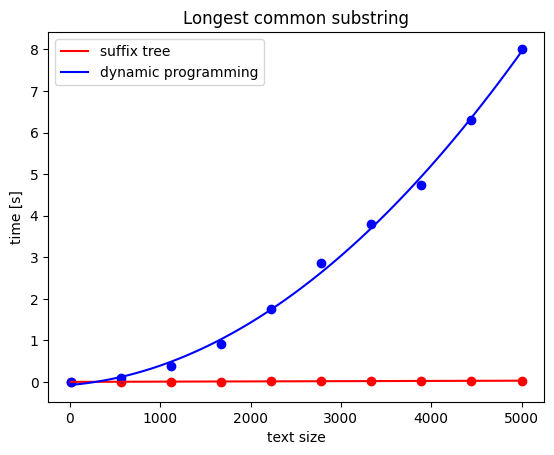

In [10]:
axis = plt.gca()
axis.set_title("Longest common substring")
axis.set_xlabel("text size")
axis.set_ylabel("time [s]")
plot_approximated(axis, text_sizes, suffix_tree_exec_times, deg = 1, c = 'red', label = "suffix tree")
plot_approximated(axis, text_sizes, dp_exec_times, deg = 2.5, c = 'blue', label = "dynamic programming")
plt.show()

#### Testy

In [12]:
class TestLCS:
    def test_basic_overlap(self):
        assert longest_common_substring("banana", "ananas") == "anana"

    def test_no_overlap(self):
        assert longest_common_substring("abc", "xyz") == ""

    def test_full_match(self):
        assert longest_common_substring("hello", "hello") == "hello"

    def test_empty_strings(self):
        assert longest_common_substring("", "") == ""
        assert longest_common_substring("abc", "") == ""
        assert longest_common_substring("", "abc") == ""

    def test_multiple_common_substrings(self):
        # Both "abc" and "bca" are common, but "abc" appears first
        assert longest_common_substring("abcabc", "bcaabc") in {"abc", "bca"}

    def test_case_sensitivity(self):
        assert longest_common_substring("ABC", "abc") == ""

    def test_longest_at_end(self):
        assert longest_common_substring("xyzabc", "defabc") == "abc"

    def test_longest_at_start(self):
        assert longest_common_substring("abcdef", "abcxyz") == "abc"

class TestLCSMultiple:
    def test_basic_overlap(self):
        assert longest_common_substring_multiple(["banana", "ananas", "canada"]) == "ana"

    def test_no_common_substring(self):
        assert longest_common_substring_multiple(["abc", "def", "ghi"]) == ""

    def test_full_match(self):
        assert longest_common_substring_multiple(["hello", "hello", "hello"]) == "hello"

    def test_empty_strings(self):
        assert longest_common_substring_multiple(["", "abc", "def"]) == ""
        assert longest_common_substring_multiple(["", "", ""]) == ""

    def test_common_at_end(self):
        assert longest_common_substring_multiple(["xyzabc", "defabc", "123abc"]) == "abc"

    def test_common_at_start(self):
        assert longest_common_substring_multiple(["abcdef", "abcxyz", "abcpqr"]) == "abc"

    def test_case_sensitivity(self):
        assert longest_common_substring_multiple(["ABC", "abc", "Abc"]) == ""

    def test_multiple_candidates(self):
        # Both "ab" and "bc" are common, but "ab" appears first in all
        assert longest_common_substring_multiple(["abxcaxbc", "zabcz", "12abc34"]) in {"ab", "bc"}

    def test_overlap_a_lot_of_texts(self):
        assert longest_common_substring_multiple(["banana", "ananas", "canada", "kanapa", "x" * 8 + "ana" + "x" * 8]) == "ana"

class TestLPS:
    def test_basic_palindrome(self):
        assert longest_palindromic_substring("babad") in {"bab", "aba"}

    def test_even_length_palindrome(self):
        assert longest_palindromic_substring("cbbd") == "bb"

    def test_reverse_substring_longer_than_palindromic_substring(self):
        assert longest_palindromic_substring("abacdfgdcaba") == "aba"
        assert longest_palindromic_substring("pqqpabcdfghfdcba") == "pqqp"

    def test_full_string_palindrome(self):
        assert longest_palindromic_substring("racecar") == "racecar"
        assert longest_palindromic_substring("a"*20) == "a"*20

    def test_single_character(self):
        assert longest_palindromic_substring("a") == "a"

    def test_empty_string(self):
        assert longest_palindromic_substring("") == ""

    def test_no_palindrome_longer_than_one(self):
        assert longest_palindromic_substring("abcde") in {"a", "b", "c", "d", "e"}

    def test_palindrome_at_start(self):
        assert longest_palindromic_substring("racecarxyz") == "racecar"

    def test_palindrome_at_end(self):
        assert longest_palindromic_substring("xyzracecar") == "racecar"

    def test_multiple_same_length(self):
        assert longest_palindromic_substring("bccbabaab") in {"bccb", "baab"}

    def test_case_sensitivity(self):
        assert longest_palindromic_substring("Aa") in {"A", "a"}


# Zadanie Sufiksy

In [13]:
from __future__ import annotations

def sorted_search(tab, val, key=lambda x: x, side = 'left'):
    beg, end = 0, len(tab) - 1
    while beg <= end:
        mid = (beg + end) // 2
        if val == key(tab[mid]):
            if side == 'left':
                end = mid - 1
            elif side == 'right':
                beg = mid + 1
            else:
                raise Exception(f"Incorrect side argument: {side}")
        elif val < key(tab[mid]):
            end = mid - 1
        else:
            beg = mid + 1
    return beg

class Suffix:
    def __init__(self, suffix: str, idx: int):
        self.suffix = suffix
        self.idx = idx

class SuffixArray:
    def __init__(self, text: str) -> None:
        self.suffixes = [0] * len(text)
        self.text = text
        self.build()

    def build(self):
        suffixes = [Suffix(self.text[idx:], idx) for idx in range(len(self.text))]
        suffixes.sort(key = lambda suff: suff.suffix)

        for i, suff in enumerate(suffixes):
            self.suffixes[i] = suff.idx

    def suffix(self, idx: int):
        return self.text[idx:]

    def find_pattern(self, pattern: str):
        if len(pattern) == 0:
            return []

        key_function = lambda x: self.suffix(x)[:len(pattern)]
        il = sorted_search(self.suffixes, pattern, key = key_function, side = 'left')
        ir = sorted_search(self.suffixes, pattern, key = key_function, side = 'right')

        return self.suffixes[il:ir]

    def __len__(self):
        return len(self.suffixes)

In [14]:
from typing import Callable
from memory_profiler import memory_usage

def measure_params(func: Callable[[str], object], *func_args) -> dict[str, float]:
    mem_usage, obj = memory_usage((func, func_args), retval=True)
    exec_time = measure_execution_time(func, *func_args)

    return {
            # "construction_time_ms": (end_time - start_time) * 1000,
            "construction_time_ms": exec_time * 1000,
            "memory_usage_kb": (max(mem_usage) - min(mem_usage)) * 1024,
            "size": len(obj)
           }


def compare_suffix_structures(text: str) -> dict:
    """
    Compare suffix array and suffix tree data structures.

    Args:
        text: The input text for which to build the structures

    Returns:
        A dictionary containing:
        - Construction time for both structures
        - Memory usage for both structures
        - Size (number of nodes/elements) of both structures
    """

    return {
        "suffix_array": measure_params(SuffixArray, text),
        "suffix_tree": measure_params(SuffixTree, text)
    }

In [23]:
suffix_tree_params = []
suffix_array_params = []

cmp_suffix_structures_text_sizes = np.linspace(10, 2.75e4, 15, dtype=int)

# for size in text_sizes:
for size in cmp_suffix_structures_text_sizes:
    # text = get_random_text(size)
    text = "a" * size
    cmp_dict = compare_suffix_structures(text)
    suffix_tree_params.append(cmp_dict["suffix_tree"])
    suffix_array_params.append(cmp_dict["suffix_array"])

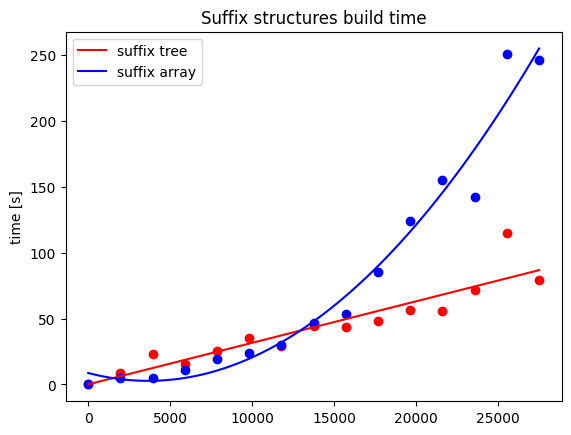

In [ ]:
axis = plt.gca()
axis.set_title("Suffix structures build time")
axis.set_ylabel("time [s]")
plot_approximated(axis, cmp_suffix_structures_text_sizes, list(map(lambda x: x["construction_time_ms"], suffix_tree_params)), deg = 1, c = 'red', label = "suffix tree")
plot_approximated(axis, cmp_suffix_structures_text_sizes, list(map(lambda x: x["construction_time_ms"], suffix_array_params)), deg = 2.5, c = 'blue', label = "suffix array")
plt.show()

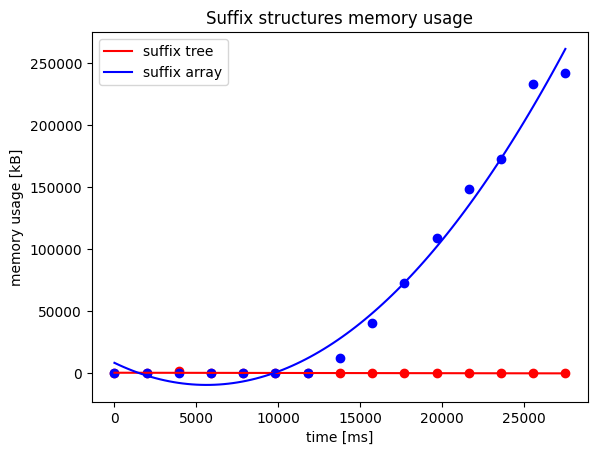

In [29]:
axis = plt.gca()
axis.set_title("Suffix structures memory usage")
plot_approximated(axis, cmp_suffix_structures_text_sizes, list(map(lambda x: x["memory_usage_kb"], suffix_tree_params)), deg = 1, c = 'red', label = "suffix tree")
plot_approximated(axis, cmp_suffix_structures_text_sizes, list(map(lambda x: x["memory_usage_kb"], suffix_array_params)), deg = 2, c = 'blue', label = "suffix array")
axis.set_ylabel("memory usage [kB]")
axis.set_xlabel("time [ms]")
plt.show()

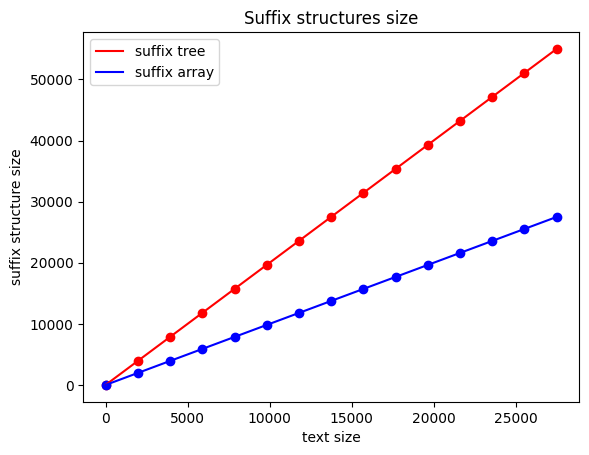

In [33]:
axis = plt.gca()
axis.set_title("Suffix structures size")
plot_approximated(axis, cmp_suffix_structures_text_sizes, list(map(lambda x: x["size"], suffix_tree_params)), deg = 1, c = 'red', label = "suffix tree")
plot_approximated(axis, cmp_suffix_structures_text_sizes, list(map(lambda x: x["size"], suffix_array_params)), deg = 1, c = 'blue', label = "suffix array")
axis.set_ylabel("suffix structure size")
axis.set_xlabel("text size")
plt.show()

#### Testy 

In [34]:
class TestSuffixTreeFindPattern:
    def test_find_pattern_basic(self):
        text = "ABABCABCABC"
        pattern = "ABC"
        suff_array = SuffixArray(text)
        result = suff_array.find_pattern(pattern)
        expected = [2, 5, 8]
        assert sorted(result) == sorted(expected), f"Oczekiwano: {expected}, otrzymano: {result}"

    def test_find_pattern_multiple_matches(self):
        text = "ABABABABABA"
        pattern = "ABA"
        suff_array = SuffixArray(text)
        result = suff_array.find_pattern(pattern)
        expected = [0, 2, 4, 6, 8]
        assert sorted(result) == sorted(expected), f"Oczekiwano: {expected}, otrzymano: {result}"

    def test_find_pattern_no_match(self):
        text = "ABCDEF"
        pattern = "XYZ"
        suff_array = SuffixArray(text)
        result = suff_array.find_pattern(pattern)
        expected = []
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"

    def test_find_pattern_empty_pattern(self):
        text = "ABCDEF"
        pattern = ""
        suff_array = SuffixArray(text)
        result = suff_array.find_pattern(pattern)
        expected = []
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"

    def test_find_pattern_empty_text(self):
        text = ""
        pattern = "ABC"
        suff_array = SuffixArray(text)
        result = suff_array.find_pattern(pattern)
        expected = []
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"

    def test_find_pattern_pattern_equals_text(self):
        text = "ABC"
        pattern = "ABC"
        suff_array = SuffixArray(text)
        result = suff_array.find_pattern(pattern)
        expected = [0]
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"

    def test_find_pattern_pattern_longer_than_text(self):
        text = "ABC"
        pattern = "ABCDEF"
        suff_array = SuffixArray(text)
        result = suff_array.find_pattern(pattern)
        expected = []
        assert sorted(result) == sorted(expected), f"Expected: {expected}, got: {result}"


In [35]:
def run_all_manual_tests():
    test_classes = [
        TestSuffixTreeBuild(),
        TestSuffixTreeFindPattern(),
        TestLCS(),
        TestLCSMultiple(),
        TestLPS(),
        TestSuffixTreeFindPattern()
    ]
    total = 0
    passed = 0
    for test_class in test_classes:
        for attr in dir(test_class):
            if attr.startswith("test_"):
                total += 1
                try:
                    getattr(test_class, attr)()
                    print(f"{test_class.__class__.__name__}.{attr}: PASSED")
                    passed += 1
                except AssertionError as e:
                    print(f"{test_class.__class__.__name__}.{attr}: FAILED\n  {e}")
                except Exception as e:
                    print(f"{test_class.__class__.__name__}.{attr}: ERROR\n  {e}")

    print(f"\n{passed}/{total} tests passed.")

run_all_manual_tests()

TestSuffixTreeBuild.test_build_tree_single_words: PASSED
TestSuffixTreeFindPattern.test_find_pattern_basic: PASSED
TestSuffixTreeFindPattern.test_find_pattern_empty_pattern: PASSED
TestSuffixTreeFindPattern.test_find_pattern_empty_text: PASSED
TestSuffixTreeFindPattern.test_find_pattern_multiple_matches: PASSED
TestSuffixTreeFindPattern.test_find_pattern_no_match: PASSED
TestSuffixTreeFindPattern.test_find_pattern_pattern_equals_text: PASSED
TestSuffixTreeFindPattern.test_find_pattern_pattern_longer_than_text: PASSED
TestLCS.test_basic_overlap: PASSED
TestLCS.test_case_sensitivity: PASSED
TestLCS.test_empty_strings: PASSED
TestLCS.test_full_match: PASSED
TestLCS.test_longest_at_end: PASSED
TestLCS.test_longest_at_start: PASSED
TestLCS.test_multiple_common_substrings: PASSED
TestLCS.test_no_overlap: PASSED
TestLCSMultiple.test_basic_overlap: PASSED
TestLCSMultiple.test_case_sensitivity: PASSED
TestLCSMultiple.test_common_at_end: PASSED
TestLCSMultiple.test_common_at_start: PASSED
TestLC

# Zadanie Porównanie

### 1. Naive

In [36]:
def cmp_texts(text1, text2):
    if len(text1) != len(text2):
        return False, 0

    char_cmp_cnt = 0
    for i in range(len(text1)):
        char_cmp_cnt += 1
        if text1[i] != text2[i]:
            return False, char_cmp_cnt

    return True, char_cmp_cnt

def naive_pattern_match(text: str, pattern: str) -> tuple[list[int], int]:
    text_len = len(text)
    pattern_len = len(pattern)
    char_cmp_cnt = 0

    if pattern_len == 0 or pattern_len > text_len:
        return [], 0

    result = []
    for i in range(text_len):
        # if text[i:min(i + pattern_len, text_len)] == pattern:
        are_the_same, common_prefix_length = cmp_texts(text[i:min(i + pattern_len, text_len)], pattern)
        char_cmp_cnt += common_prefix_length
        if are_the_same:
            result.append(i)

    return result, char_cmp_cnt

### 2. KMP

In [37]:
def compute_lps_array(pattern: str) -> tuple[list[int], int]:
    lps = [0] * len(pattern)
    length = 0  # Length of the previous longest prefix suffix
    i = 1

    char_cmp_count = 0

    while i < len(pattern):
        char_cmp_count += 1
        if pattern[i] == pattern[length]:
            length += 1
            lps[i] = length
            i += 1
        else:
            if length != 0:
                length = lps[length - 1]
            else:
                lps[i] = 0
                i += 1

    return lps, char_cmp_count

def kmp_pattern_match(text: str, pattern: str) -> tuple[list[int], int]:
    text_len = len(text)
    pattern_len = len(pattern)

    if text_len < pattern_len or pattern_len == 0:
        return [], 0

    result = []

    p, char_cmp_count = compute_lps_array(pattern)
    j = 0

    for i in range(len(text)):
        char_cmp_count += 1
        while j > 0 and text[i] != pattern[j]:
            char_cmp_count += 1
            j = p[j - 1]

        char_cmp_count += 1
        if text[i] == pattern[j]:
            j += 1

        if j == len(pattern):
            result.append(i - len(pattern) + 1)
            j = p[j - 1]

    return result, char_cmp_count


### 3. Boyer-Moore

In [38]:
def compute_bad_character_table(pattern: str) -> dict:
    rightmost_occurences = {}
    for i, char in enumerate(pattern):
        rightmost_occurences[char] = i

    return rightmost_occurences

def compute_good_suffix_table(pattern: str) -> tuple[list[int], int]:
    pattern_len = len(pattern)
    good_suffix_table = [0] * (pattern_len + 1)
    border_pos = [0] * (pattern_len + 1)

    i = pattern_len
    j = pattern_len + 1
    border_pos[i] = j

    char_cmp_cnt = 0

    while i > 0:
        char_cmp_cnt += 1
        while j <= pattern_len and pattern[i - 1] != pattern[j - 1]:
            char_cmp_cnt += 1
            if good_suffix_table[j] == 0:
                good_suffix_table[j] = j - i
            j = border_pos[j]
        i -= 1
        j -= 1
        border_pos[i] = j

    j = border_pos[0]
    for i in range(pattern_len + 1):
        if good_suffix_table[i] == 0:
            good_suffix_table[i] = j
        if i == j:
            j = border_pos[j]

    return good_suffix_table, char_cmp_cnt

def boyer_moore_pattern_match(text: str, pattern: str) -> tuple[list[int], int]:
    text_len = len(text)
    pattern_len = len(pattern)

    if pattern_len == 0 or text_len < pattern_len:
        return [], 0

    bad_char_table = compute_bad_character_table(pattern)
    good_suffix_table, char_cmp_cnt = compute_good_suffix_table(pattern)
    char_cmp_cnt += len(pattern) # add comparisions from 'compute_bad_character_table(pattern)' call

    result = []
    i = 0

    while i <= text_len - pattern_len:
        j = pattern_len - 1

        char_cmp_cnt += 1
        while j >= 0 and pattern[j] == text[i + j]:
            char_cmp_cnt += 1
            j -= 1

        if j < 0:
            result.append(i)

            i += good_suffix_table[0]
        else:
            bad_char_shift = j - bad_char_table.get(text[i + j], -1)
            good_suffix_shift = good_suffix_table[j + 1]
            i += max(bad_char_shift, good_suffix_shift)

    return result, char_cmp_cnt


### 4. Rabin-Karp

In [39]:
def cmp_texts(text1, text2):
    if len(text1) != len(text2):
        return False, 0

    char_cmp_cnt = 0
    for i in range(len(text1)):
        char_cmp_cnt += 1
        if text1[i] != text2[i]:
            return False, char_cmp_cnt

    return True, char_cmp_cnt

def hash_byte(curr_hash: int, byte: int, mod: int = 101):
    return (curr_hash + byte) % mod

def unhash_byte(curr_hash: int, byte: int, mod: int = 101):
    return (curr_hash - byte + mod) % mod

def hash_string(substr: str, mod: int = 101):
    hash_res = 0
    for char in substr:
        hash_res = hash_byte(hash_res, ord(char), mod)

    return hash_res

def rabin_karp_pattern_match(text: str, pattern: str, prime: int = 101) -> tuple[list[int], int]:
    result = []
    text_len = len(text)
    pattern_len = len(pattern)

    if pattern_len == 0 or text_len < pattern_len:
        return [], 0

    pattern_hash = hash_string(pattern, prime)
    curr_hash = hash_string(text[:pattern_len], prime)

    char_cmp_cnt = 0

    i = 0
    while True:
        if curr_hash == pattern_hash and text[i:i+pattern_len] == pattern:
            are_the_same, common_prefix_length = cmp_texts(text[i:i+pattern_len], pattern)
            char_cmp_cnt += common_prefix_length
            if are_the_same:
                result.append(i)

        if text_len <= i + pattern_len:
            break

        curr_hash = hash_byte(curr_hash, ord(text[i+pattern_len]))
        curr_hash = unhash_byte(curr_hash, ord(text[i]), prime)

        i += 1

    return result, char_cmp_cnt


### 5. Aho-Corasick

In [40]:
from __future__ import annotations
from collections import deque
from typing import List, Tuple, Optional
from overrides import override

class AhoCorasickNode:
    def __init__(self, character: str, node_depth: int, is_terminal_node: bool = False):
        self.character: str = character
        self.goto_nodes: dict[str, AhoCorasickNode] = {}
        self.fail_link: Optional[AhoCorasickNode] = None
        self.output_link: Optional[AhoCorasickNode] = None
        self.node_depth: int = node_depth
        self.is_terminal_node: bool = is_terminal_node
        self.pattern: str = ""

    def get_character(self):
        return self.character

    def goto(self, character: str) -> Optional[AhoCorasickNode]:
        return self.goto_nodes.get(character, None)

    def fail(self) -> Optional[AhoCorasickNode]:
        return self.fail_link

    def output(self) -> Optional[AhoCorasickNode]:
        return self.output_link

    def depth(self) -> int:
        return self.node_depth

    def is_terminal(self) -> bool:
        return self.is_terminal_node

    def add_goto(self, character: str, goto_node: AhoCorasickNode):
        assert character not in self.goto_nodes, f"goto node for character={character} already defined!!!"

        self.goto_nodes[character] = goto_node

    def set_fail(self, fail_node: Optional[AhoCorasickNode]):
        self.fail_link = fail_node

    def set_output(self, output_node: Optional[AhoCorasickNode]):
        self.output_link = output_node

    def set_is_terminal(self, is_terminal_node: bool):
        self.is_terminal_node = is_terminal_node

    def set_pattern(self, pattern: str):
        self.pattern = pattern

    def __repr__(self):
        return f'AhoCorasickNode(\'{self.character}\', {self.node_depth}, is_terminal={self.is_terminal_node}, ' + \
            f'fail=({None if self.fail_link is None else f"{self.fail_link.get_character()}, {self.fail_link.depth()}"}), ' + \
            f'output=({None if self.output_link is None else f"{self.output_link.get_character()}, {self.output_link.depth()}"}))'

class AhoCorasickRootNode(AhoCorasickNode):
    def __init__(self):
        super().__init__('', 0, is_terminal_node = False)

    @override
    def goto(self, character: str) -> Optional[AhoCorasickNode]:
        if character not in self.goto_nodes:
            return self

        return super().goto(character)

class AhoCorasick:
    def __init__(self, patterns: List[str]):
        self.patterns = list(filter(lambda x: len(x) > 0, patterns))
        self.root: AhoCorasickNode = AhoCorasickRootNode()
        self._build_trie()
        self._build_failure_links()

    def _build_trie(self):
        for pattern in self.patterns:
            char = pattern[0]

            if self.root.goto(char) == self.root:
                new_node = AhoCorasickNode(char, 1, is_terminal_node = len(pattern) == 1)
                self.root.add_goto(char, new_node)

        for pattern in self.patterns:
            current_node = self.root

            for depth, char in enumerate(pattern, start = 1):
                next_node = current_node.goto(char)

                if next_node is None:
                    next_node = AhoCorasickNode(char, depth)
                    current_node.add_goto(char, next_node)

                current_node = next_node

            current_node.set_is_terminal(True)
            current_node.set_pattern(pattern)

    def _build_failure_links(self):
        queue: deque[AhoCorasickNode] = deque([self.root])

        while queue:
            current_node = queue.popleft()

            for char, goto_node in current_node.goto_nodes.items():
                queue.append(goto_node)

                if current_node is self.root:
                    goto_node.set_fail(self.root)

                fail_node = current_node.fail()

                while fail_node is not None and fail_node is not self.root and fail_node.goto(char) is None:
                    fail_node = fail_node.fail()

                if fail_node is not None and fail_node.goto(char) is not None:
                    goto_node.set_fail(fail_node.goto(char))
                else:
                    goto_node.set_fail(self.root)

            output_node = current_node.fail()

            while output_node is not None and not output_node.is_terminal():
                output_node = output_node.fail()

            current_node.set_output(output_node)

    def search(self, text: str) -> Tuple[List[int], int]:
        char_cmp_cnt = 0
        result = []

        current_node: AhoCorasickNode = self.root

        for position, char in enumerate(text):
            char_cmp_cnt += 1
            while current_node.goto(char) is None:
                char_cmp_cnt += 1
                current_node = current_node.fail()

            current_node = current_node.goto(char)

            if current_node.is_terminal():
                result.append(position - current_node.depth() + 1)

            output_node = current_node.output()

            while output_node is not None:
                result.append(position - output_node.depth() + 1)
                output_node = output_node.output()

        return result, char_cmp_cnt

    def __print_help(self, current_node: AhoCorasickNode, current_path: str, current_string: str):
        next_nodes = current_node.goto_nodes

        if not next_nodes:
            print(f"current string: {current_string}")
            print(f"current path: {current_path}")
            print()
            return

        for char, next_node in next_nodes.items():
            self.__print_help(next_node, f"{current_path} -> {next_node}\n", current_string + char)

    def print(self):
        self.__print_help(self.root, f"{self.root}\n", "")

#### 6. Suffix array

In [41]:
from __future__ import annotations

def compare_strings(str1, str2):
    comparisons = 0
    min_len = min(len(str1), len(str2))

    for i in range(min_len):
        comparisons += 1
        if str1[i] < str2[i]:
            return -1, comparisons
        elif str1[i] > str2[i]:
            return 1, comparisons

    if len(str1) < len(str2):
        return -1, comparisons + 1
    elif len(str1) > len(str2):
        return 1, comparisons + 1
    else:
        return 0, comparisons

def sorted_search(tab, val, key=lambda x: x, side = 'left'):
    beg, end = 0, len(tab) - 1
    char_cmp_cnt = 0
    while beg <= end:
        mid = (beg + end) // 2
        cmp, common_prefix_length = compare_strings(val, key(tab[mid]))
        if cmp == 0:
            if side == 'left':
                end = mid - 1
            elif side == 'right':
                beg = mid + 1
            else:
                raise Exception(f"Incorrect side argument: {side}")
        elif cmp == -1:
            end = mid - 1
        else:
            beg = mid + 1
    return beg, char_cmp_cnt

class Suffix:
    def __init__(self, suffix: str, idx: int):
        self.suffix = suffix
        self.idx = idx

    def __repr__(self):
        return self.suffix

class SuffixArrayModified:
    def __init__(self, text: str) -> None:
        self.suffixes = [0] * len(text)
        self.text = text
        self.build()

    def build(self):
        suffixes = [Suffix(self.text[idx:], idx) for idx in range(len(self.text))]
        suffixes.sort(key = lambda suff: suff.suffix)

        for i, suff in enumerate(suffixes):
            self.suffixes[i] = suff.idx

    def suffix(self, idx: int):
        return self.text[idx:]

    def find_pattern(self, pattern: str):
        if len(pattern) == 0:
            return [], 0

        key_function = lambda x: self.suffix(x)[:len(pattern)]
        il, char_cmp_cnt = sorted_search(self.suffixes, pattern, key = key_function, side = 'left')
        ir, cmp_cnt = sorted_search(self.suffixes, pattern, key = key_function, side = 'right')
        char_cmp_cnt += cmp_cnt

        return self.suffixes[il:ir], char_cmp_cnt

    def __len__(self):
        return len(self.suffixes)


### 7. Suffix tree

In [42]:
from __future__ import annotations
from typing import Optional
from collections import deque

class IntRef:
    def __init__(self, value):
        self.value = value

class Node:
    text: str = ""
    def __init__(self, end: IntRef, start: int = -1, id: int = -1, suffix_link: Optional[Node] = None):
        self.children: dict[str, Node] = {}
        self.suffix_link: Optional[Node] = suffix_link
        self.start: int = start
        self.end: IntRef = end
        self.id: int = id

    def width(self):
        return self.end.value - self.start + 1

    def debug_str(self):
        return f"Node(\"{self.text[self.start:self.end.value + 1]}\", start: {self.start}, end: {self.end.value} id: {self.id}, link: {self.suffix_link})"

    def __repr__(self):
        return f"Node(\"{self.text[self.start:self.end.value + 1]}\")"

class SuffixTreeModified:
    def __init__(self, text: str):
        self.guardian: str = "$"
        self.end_ref: IntRef = IntRef(0)
        self.text: str = text + self.guardian
        self.root: Node = Node(IntRef(-1), start=0)
        self.active_node: Node = self.root
        self.active_edge: int = 0
        self.active_length: int = 0
        self.remainder: int = 0
        self.leaf_id: int = 0
        self.inner_node_cnt: int = 0

        Node.text = self.text

        self.build_tree()

        self.leaf_cnt = self.leaf_id

    def build_tree(self):
        """
        Build the suffix tree using Ukkonen's algorithm.
        """
        text_len = len(self.text)
        self.remainder = 0

        for i in range(text_len):
            self.extend_tree(i)

    def get_node_first_char(self, node: Node):
        return self.text[node.start]

    def add_child_node(self, parent: Node, child: Node):
        parent.children[self.get_node_first_char(child)] = child

    def get_current_child(self):
        return self.active_node.children[self.get_active_edge_char()]

    def get_active_edge_char(self):
        return self.text[self.active_edge]

    def create_leaf(self, start: int):
        leaf = Node(end = self.end_ref, start = start, id = self.leaf_id)
        self.leaf_id += 1

        return leaf

    def extend_tree(self, position):
        self.end_ref.value = position
        curr_char = self.text[position]
        last_added_node: Optional[Node] = None
        self.remainder += 1

        while self.remainder > 0:
            if self.active_length == 0:
                self.active_edge = position

            if self.get_active_edge_char() not in self.active_node.children:
                new_leaf = self.create_leaf(position)
                self.add_child_node(self.active_node, new_leaf)

                if last_added_node is not None:
                    last_added_node.suffix_link = self.active_node
                    last_added_node = None
            else:
                curr_child = self.get_current_child()
                idx = curr_child.start + self.active_length

                # update current node if exceeding it's length
                if curr_child.width() <= self.active_length:
                    self.active_node = curr_child
                    self.active_length -= curr_child.width()
                    self.active_edge += curr_child.width()
                    continue

                # check if we don't have to devide current active_edge
                if self.text[idx] == curr_char:
                    if last_added_node is not None:
                        last_added_node.suffix_link = self.active_node
                    self.active_length += 1
                    break

                inner_node_end_ref = IntRef(curr_child.start + self.active_length - 1)
                inner_node = Node(end = inner_node_end_ref, start = curr_child.start)
                self.inner_node_cnt += 1
                self.add_child_node(self.active_node, inner_node)

                if last_added_node is not None:
                    last_added_node.suffix_link = inner_node

                curr_child.start = inner_node.end.value + 1
                new_leaf = self.create_leaf(position)

                self.add_child_node(inner_node, curr_child)
                self.add_child_node(inner_node, new_leaf)

                last_added_node = inner_node

                if self.active_node is self.root:
                    self.active_length -= 1
                    self.active_edge += 1

            self.remainder -= 1
            if self.active_node is not self.root:
                if self.active_node.suffix_link is not None:
                    self.active_node = self.active_node.suffix_link
                else:
                    self.active_node = self.root

    def find_pattern(self, pattern: str) -> tuple[list[int], int]:
        if len(pattern) == 0:
            return [], 0

        if pattern[0] not in self.root.children:
            return [], 1

        curr_node = self.root.children[pattern[0]]
        pattern_found = True

        char_cmp_cnt = 0

        pos = 0

        for i in range(1, len(pattern)):
            char = pattern[i]
            pos += 1
            if pos < curr_node.width():
                char_cmp_cnt += 1
                if char != self.text[curr_node.start + pos]:
                    pattern_found = False
                    break
            else:
                char_cmp_cnt += 1
                if char in curr_node.children:
                    curr_node = curr_node.children[char]
                    pos = 0
                else:
                    pattern_found = False
                    break

        if not pattern_found:
            return [], char_cmp_cnt

        result = []
        to_check = deque([curr_node])

        while to_check:
            node = to_check.popleft()

            if not node.children:
                result.append(node.id)
                continue

            for child_node in node.children.values():
                to_check.append(child_node)

        return result, char_cmp_cnt

    def __print_help(self, current_node: Node, current_path: str, current_string: str):
        next_nodes = current_node.children

        if not next_nodes:
            print(f"current string: {current_string + self.text[current_node.start:current_node.end.value + 1]}")
            print(f"current path: {current_path}")
            print()
            return

        for next_node in next_nodes.values():
            self.__print_help(next_node, f"{current_path} -> {next_node.debug_str()}\n", current_string + self.text[current_node.start:current_node.end.value + 1])

    def print(self):
        self.__print_help(self.root, f"{self.root.debug_str()}\n", "")

    def contains_suffix(self, suffix: str):
        if suffix[0] not in self.root.children:
            return False

        curr_node = self.root.children[suffix[0]]
        pos = 0

        for char in suffix[1:]:
            pos += 1
            if pos < curr_node.width():
                if char != self.text[curr_node.start + pos]:
                    return False
            else:
                if char in curr_node.children:
                    curr_node = curr_node.children[char]
                    pos = 0
                else:
                    return False

        return True

    def get_leaves_cnt(self):
        return self.leaf_cnt

    def get_inner_nodes_cnt(self):
        return self.inner_node_cnt

    def __len__(self):
        return self.get_inner_nodes_cnt() + self.get_leaves_cnt()


In [ ]:
from memory_profiler import memory_usage
from typing import Callable

def compare_pattern_matching_algorithms(text: str, pattern: str) -> dict:
    """
    Compare the performance of different pattern matching algorithms.

    Args:
        text: The text to search in
        pattern: The pattern to search for

    Returns:
        A dictionary containing the results of each algorithm:
        - Execution time in milliseconds
        - Memory usage in kilobytes
        - Number of character comparisons made
        - Positions where the pattern was found
    """
    def measure_params(func: Callable[[str, str], tuple[list[int], int]] | Callable[[str], tuple[list[int], int]], *func_args) -> dict[str, float]:
        mem_usage, res = memory_usage((func, func_args), retval=True)
        exec_time = measure_execution_time(func, *func_args)
        pattern_found, char_cmp_cnt = res

        return {
            "exec_time": exec_time,
            "mem_usage": (max(mem_usage) - min(mem_usage)) * 1024,
            "char_cmp_cnt": char_cmp_cnt,
            "pattern_found": pattern_found
        }

    args = text, pattern

    aho_corasick = AhoCorasick([pattern])
    suff_arr = SuffixArrayModified(text)
    suff_tree = SuffixTreeModified(text)

    return {
        "naive": measure_params(naive_pattern_match, *args),
        "kmp": measure_params(kmp_pattern_match, *args),
        "boyer-moore": measure_params(boyer_moore_pattern_match, *args),
        "rabin-karp": measure_params(rabin_karp_pattern_match, *args),
        "aho-corasick": measure_params(aho_corasick.search, text),
        "suffix-array": measure_params(suff_arr.find_pattern, pattern),
        "suffix-tree": measure_params(suff_tree.find_pattern, pattern),
    }


In [ ]:
naive_pattern_matching_params = []
kmp_pattern_matching_params = []
boyer_moore_pattern_matching_params = []
rabin_karp_pattern_matching_params = []
aho_corasick_pattern_matching_params = []
suffix_array_pattern_matching_params = []
suffix_tree_pattern_matching_params = []

cmp_pattern_matching_text_sizes = np.linspace(10, 1e2, 10, dtype=int)

for i, size in enumerate(cmp_pattern_matching_text_sizes):
    text = get_random_text(size)
    pattern = get_random_text(int(np.sqrt(size)) + 1)
    cmp_dict = compare_pattern_matching_algorithms(text, pattern)
    naive_pattern_matching_params.append(cmp_dict["naive"])
    kmp_pattern_matching_params.append(cmp_dict["kmp"])
    boyer_moore_pattern_matching_params.append(cmp_dict["boyer-moore"])
    rabin_karp_pattern_matching_params.append(cmp_dict["rabin-karp"])
    aho_corasick_pattern_matching_params.append(cmp_dict["aho-corasick"])
    suffix_array_pattern_matching_params.append(cmp_dict["suffix-array"])
    suffix_tree_pattern_matching_params.append(cmp_dict["suffix-tree"])

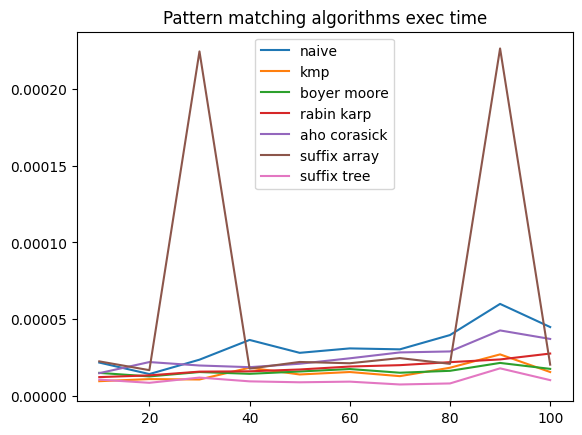

In [64]:
plt.title("Pattern matching algorithms exec time")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], naive_pattern_matching_params)), label = "naive")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], kmp_pattern_matching_params)), label = "kmp")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], boyer_moore_pattern_matching_params)), label = "boyer moore")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], rabin_karp_pattern_matching_params)), label = "rabin karp")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], aho_corasick_pattern_matching_params)), label = "aho corasick")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], suffix_array_pattern_matching_params)), label = "suffix array")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], suffix_tree_pattern_matching_params)), label = "suffix tree")
plt.legend()
plt.show()

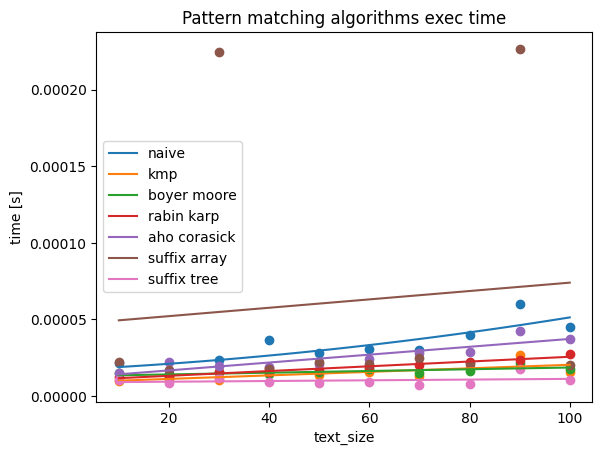

In [65]:
axis = plt.gca()
axis.set_title("Pattern matching algorithms exec time")
axis.set_xlabel("text_size")
axis.set_ylabel("time [s]")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], naive_pattern_matching_params)), deg = 2, label = "naive")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], kmp_pattern_matching_params)), deg = 1, label = "kmp")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], boyer_moore_pattern_matching_params)), deg = 1, label = "boyer moore")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], rabin_karp_pattern_matching_params)), deg = 1, label = "rabin karp")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], aho_corasick_pattern_matching_params)), deg = 1, label = "aho corasick")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], suffix_array_pattern_matching_params)), deg = 1, label = "suffix array")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["exec_time"], suffix_tree_pattern_matching_params)), deg = 1, label = "suffix tree")
plt.show()

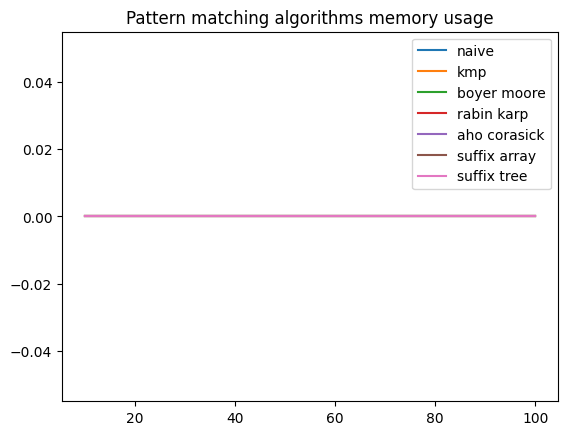

In [62]:
plt.title("Pattern matching algorithms memory usage")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["mem_usage"], naive_pattern_matching_params)), label = "naive")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["mem_usage"], kmp_pattern_matching_params)), label = "kmp")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["mem_usage"], boyer_moore_pattern_matching_params)), label = "boyer moore")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["mem_usage"], rabin_karp_pattern_matching_params)), label = "rabin karp")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["mem_usage"], aho_corasick_pattern_matching_params)), label = "aho corasick")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["mem_usage"], suffix_array_pattern_matching_params)), label = "suffix array")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["mem_usage"], suffix_tree_pattern_matching_params)), label = "suffix tree")
plt.legend()
plt.show()

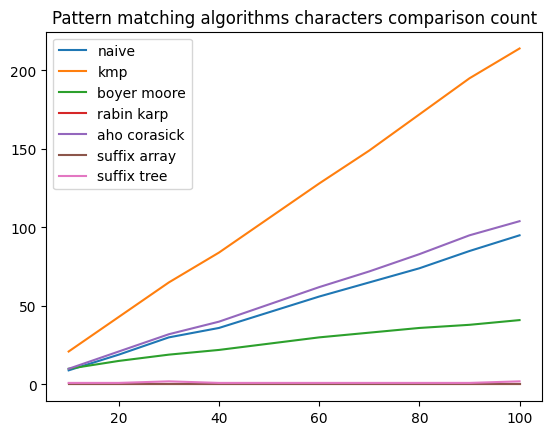

In [61]:
plt.title("Pattern matching algorithms characters comparison count")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], naive_pattern_matching_params)), label = "naive")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], kmp_pattern_matching_params)), label = "kmp")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], boyer_moore_pattern_matching_params)), label = "boyer moore")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], rabin_karp_pattern_matching_params)), label = "rabin karp")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], aho_corasick_pattern_matching_params)), label = "aho corasick")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], suffix_array_pattern_matching_params)), label = "suffix array")
plt.plot(cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], suffix_tree_pattern_matching_params)), label = "suffix tree")
plt.legend()
plt.show()

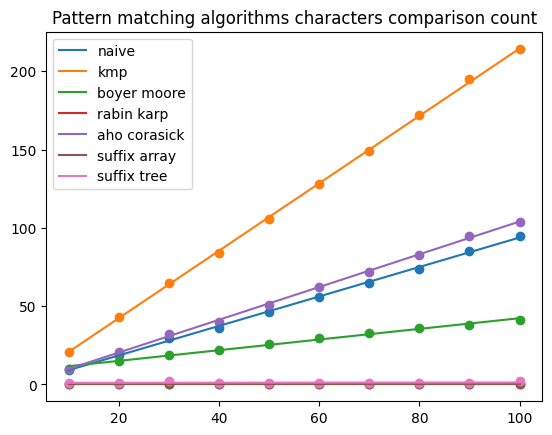

In [60]:
axis = plt.gca()
axis.set_title("Pattern matching algorithms characters comparison count")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], naive_pattern_matching_params)), deg = 1, label = "naive")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], kmp_pattern_matching_params)), deg = 1, label = "kmp")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], boyer_moore_pattern_matching_params)), deg = 1, label = "boyer moore")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], rabin_karp_pattern_matching_params)), deg = 1, label = "rabin karp")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], aho_corasick_pattern_matching_params)), deg = 1, label = "aho corasick")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], suffix_array_pattern_matching_params)), deg = 1, label = "suffix array")
plot_approximated(axis, cmp_pattern_matching_text_sizes, list(map(lambda x: x["char_cmp_cnt"], suffix_tree_pattern_matching_params)), deg = 1, label = "suffix tree")
plt.show()

In [79]:
def compare_pattern_matching_algorithms_by_pattern_size(text: str, patterns):
    suff_arr = SuffixArrayModified(text)
    suff_tree = SuffixTreeModified(text)

    res = {
        "naive": [],
        "kmp": [],
        "boyer-moore": [],
        "rabin-karp": [],
        "aho-corasick": [],
        "suffix-array": [],
        "suffix-tree": []
    }

    for pattern in patterns:
        aho_corasick = AhoCorasick([pattern])
        res["naive"].append(measure_execution_time(naive_pattern_match, text, pattern))
        res["kmp"].append(measure_execution_time(kmp_pattern_match, text, pattern))
        res["boyer-moore"].append(measure_execution_time(boyer_moore_pattern_match, text, pattern))
        res["rabin-karp"].append(measure_execution_time(rabin_karp_pattern_match, text, pattern))
        res["aho-corasick"].append(measure_execution_time(aho_corasick.search, text))
        res["suffix-array"].append(measure_execution_time(suff_arr.find_pattern, pattern))
        res["suffix-tree"].append(measure_execution_time(suff_tree.find_pattern, pattern))

    return res

In [101]:
cmp_pattern_match_by_pattern_size_text_size = 50000
cmp_pattern_match_by_pattern_size_text = get_random_text(cmp_pattern_match_by_pattern_size_text_size)
cmp_pattern_match_by_pattern_size_pattern_sizes = np.linspace(10, cmp_pattern_match_by_pattern_size_text_size, 20, dtype=int)
cmp_pattern_match_by_pattern_size_patterns = map(get_random_text, cmp_pattern_match_by_pattern_size_pattern_sizes)

In [103]:
cmp_pattern_match_by_pattern_size_results = compare_pattern_matching_algorithms_by_pattern_size(
    cmp_pattern_match_by_pattern_size_text,
    cmp_pattern_match_by_pattern_size_patterns
)

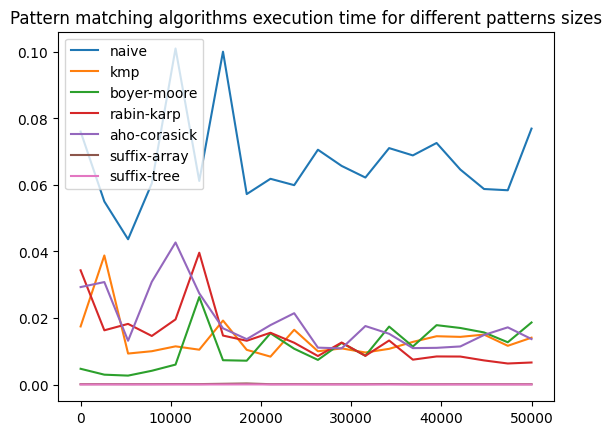

In [104]:
axis = plt.gca()
axis.set_title("Pattern matching algorithms execution time for different patterns sizes")
plt.plot(cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["naive"], label = "naive")
plt.plot(cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["kmp"], label = "kmp")
plt.plot(cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["boyer-moore"], label = "boyer-moore")
plt.plot(cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["rabin-karp"], label = "rabin-karp")
plt.plot(cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["aho-corasick"], label = "aho-corasick")
plt.plot(cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["suffix-array"], label = "suffix-array")
plt.plot(cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["suffix-tree"], label = "suffix-tree")
plt.legend()
plt.show()

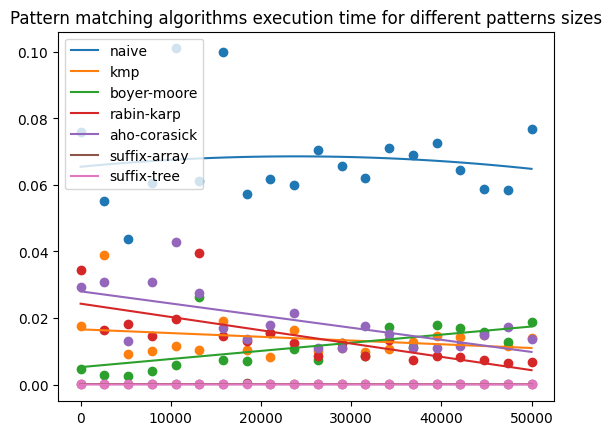

In [105]:
axis = plt.gca()
axis.set_title("Pattern matching algorithms execution time for different patterns sizes")
plot_approximated(axis, cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["naive"], deg = 2, label = "naive")
plot_approximated(axis, cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["kmp"], deg = 1, label = "kmp")
plot_approximated(axis, cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["boyer-moore"], deg = 1, label = "boyer-moore")
plot_approximated(axis, cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["rabin-karp"], deg = 1, label = "rabin-karp")
plot_approximated(axis, cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["aho-corasick"], deg = 1, label = "aho-corasick")
plot_approximated(axis, cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["suffix-array"], deg = 1, label = "suffix-array")
plot_approximated(axis, cmp_pattern_match_by_pattern_size_pattern_sizes, cmp_pattern_match_by_pattern_size_results["suffix-tree"], deg = 1, label = "suffix-tree")
plt.show()